In [60]:
import torch
from typing import Union, List, Dict, cast, Any
import torch.nn as nn
from PIL import Image
import cv2
from torchinfo import summary
from torchvision.transforms import ToTensor
import polars as pl
from os.path import exists, join
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [9]:
cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [10]:
class VGG(nn.Module):
    def __init__(self, features, num_classes):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [11]:

def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(True)]
            else:
                layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)

def _vgg(arch: str, cfg: str, batch_norm: bool, **kwargs: Any) -> VGG:
    model = VGG(make_layers(cfg=cfgs[cfg], batch_norm=batch_norm), **kwargs)
    return model

def vgg16(**kwargs: Any)->VGG:
    return _vgg('vgg16', 'D', False, **kwargs)

# data load

In [52]:
df = pl.read_csv("../../datasets/COVID/covid_data.csv")
csv_path= "../../datasets/COVID/covid_data.csv"

In [53]:
class DataCsvParser():
    def __init__(self, csv_path: str):
        import os
        import polars as pl
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"CSV file not found: {csv_path}")

        self.df = pl.read_csv(csv_path)

    def data_path(self, mode):
        """
        特定のmodeに対応するpath列の値をリストとして返すプロパティ
        """
        try:
            return self.df.filter(pl.col("mode") == mode).get_column("path").to_list()
        except AttributeError:
            return []


In [64]:
class VGGDataset(Dataset):
    def __init__(self, csv_path: str, mode: str, transform=None) -> None:
        super().__init__()
        self.csv_path = csv_path
        self.mode = mode
        self.transform = transform
        self.data_path = DataCsvParser(csv_path=csv_path).data_path(self.mode)
    
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, index) -> Any:
        image = cv2.imread(self.data_path[index], 0)
        if self.transform is not None:
            image = self.transform(image)
        return image


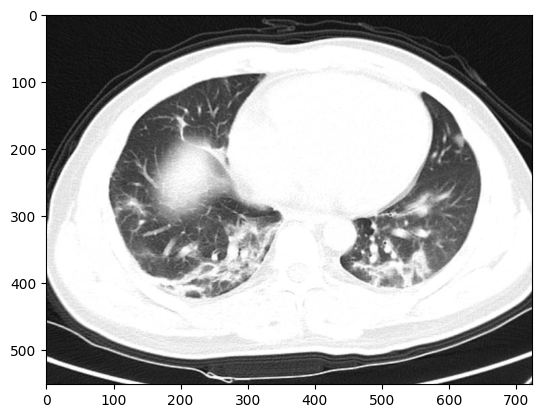

In [65]:
dataset = VGGDataset(csv_path=csv_path, mode="train")
plt.imshow(dataset[0], cmap="gray")

In [14]:
model = vgg16(num_classes=10)

In [15]:
odel(image_tensor)

tensor([[-0.0067,  0.0069,  0.0015,  0.0067, -0.0148,  0.0101, -0.0113,  0.0051,
          0.0071,  0.0037]], grad_fn=<AddmmBackward0>)

In [31]:
512*7*7

25088